In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt

In [8]:
from __future__ import print_function
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
from keras import applications
from keras.models import Model, load_model
import numpy as np
from sklearn.metrics import confusion_matrix

from time import time

In [3]:
# Data generators, data augmentation
batch_size = 32

train = ImageDataGenerator(rotation_range = 15.0,
    horizontal_flip = True)

test = ImageDataGenerator(rotation_range = 15.0,
    horizontal_flip = True)

In [4]:
# Target directories 
trainGenerator = train.flow_from_directory('../data/trashnet/_train_', target_size = (224, 224), batch_size=batch_size,
    class_mode = "categorical", color_mode = "rgb", shuffle=True, seed=42)

testGenerator = test.flow_from_directory('../data/trashnet/_test_', target_size = (224, 224), batch_size=1,
    class_mode = "categorical", color_mode = "rgb", shuffle=True, seed=42)

validationGenerator = test.flow_from_directory('../data/trashnet/_valid_', target_size = (224, 224), batch_size=batch_size,
    class_mode = "categorical", color_mode = "rgb", shuffle=True, seed=42)

Found 1620 images belonging to 6 classes.
Found 504 images belonging to 6 classes.
Found 403 images belonging to 6 classes.


In [5]:
# Neural network
base = applications.densenet.DenseNet169(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

x = Flatten()(base.output)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)
model = Model(inputs=base.inputs, outputs=x)

In [50]:
# Print a summary of the network
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [51]:
# Set optimizer and loss function
opt = keras.optimizers.SGD(lr = 0.0001, momentum = 0.01)
optt = keras.optimizers.RMSprop(lr = 0.0001)
opt_adam = keras.optimizers.Adam(lr=0.0001, amsgrad=True)
model.compile(loss='categorical_crossentropy',
            optimizer=opt_adam,
            metrics=['categorical_accuracy'])

In [6]:
# callbacks
tensorboard = TensorBoard(log_dir="logs/minc-2500-{}-VGG19-bs32".format(time()))
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, min_delta=1e-2)
checkpoint = keras.callbacks.ModelCheckpoint('minc-2500-weights.{epoch:02d}-{val_loss:.2f}-VGG19-bs32.hdf5', monitor='val_loss', 
        verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)

In [53]:
# Fit the model!
model.fit_generator(trainGenerator,
            steps_per_epoch = 2000,
            epochs = 50,
            validation_data = validationGenerator,
            validation_steps = 800,
            callbacks=[tensorboard, reduce_lr, checkpoint])

Epoch 1/50
2000/2000 [==============================] - 1036s 518ms/step - loss: 1.5999 - categorical_accuracy: 0.2550 - val_loss: 1.4078 - val_categorical_accuracy: 0.4045

Epoch 00001: val_loss improved from inf to 1.40775, saving model to minc-2500-weights.01-1.41-VGG19-bs32.hdf5
Epoch 2/50
2000/2000 [==============================] - 1070s 535ms/step - loss: 1.1464 - categorical_accuracy: 0.5435 - val_loss: 0.9609 - val_categorical_accuracy: 0.6340

Epoch 00002: val_loss improved from 1.40775 to 0.96091, saving model to minc-2500-weights.02-0.96-VGG19-bs32.hdf5
Epoch 3/50
2000/2000 [==============================] - 974s 487ms/step - loss: 0.7728 - categorical_accuracy: 0.7184 - val_loss: 0.7839 - val_categorical_accuracy: 0.7316

Epoch 00003: val_loss improved from 0.96091 to 0.78389, saving model to minc-2500-weights.03-0.78-VGG19-bs32.hdf5
Epoch 4/50
2000/2000 [==============================] - 994s 497ms/step - loss: 0.6220 - categorical_accuracy: 0.7762 - val_loss: 0.7247 - va

In [7]:
from keras.models import load_model
model = load_model('GUI-Model-trashnet-weights.30-0.20-DenseNet169.hdf5', compile=False)
opt_adam = keras.optimizers.Adam(lr=0.0001, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['categorical_accuracy', 
                                                                            'mean_squared_error', 
                                                                            'mean_absolute_error', 
                                                                            'mean_squared_logarithmic_error'])

Confusion Matrix


NameError: name 'confusion_matrix' is not defined

In [31]:
Y_pred = model.predict_generator(testGenerator, 504)
y_pred = np.argmax(Y_pred, axis=1)

In [32]:
print('Confusion Matrix')
print(confusion_matrix(testGenerator.classes, y_pred))

Confusion Matrix
[[14 15 16 15 14  6]
 [11 18 22 26 18  5]
 [10 13 18 22 11  8]
 [28 18 17 26 25  5]
 [20 22 14 26 11  3]
 [ 6  4  6  7  1  3]]


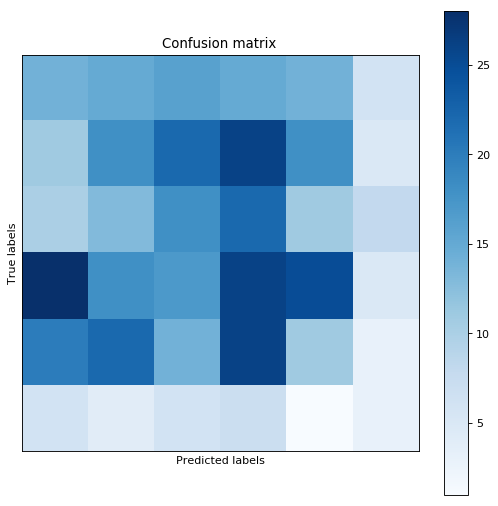

In [33]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(testGenerator.classes, y_pred)
# or
#cm = np.array([[1401,    0],[1112, 0]])

plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

Confusion matrix, without normalization
[[14 15 16 15 14  6]
 [11 18 22 26 18  5]
 [10 13 18 22 11  8]
 [28 18 17 26 25  5]
 [20 22 14 26 11  3]
 [ 6  4  6  7  1  3]]
Normalized confusion matrix
[[0.17 0.19 0.2  0.19 0.17 0.07]
 [0.11 0.18 0.22 0.26 0.18 0.05]
 [0.12 0.16 0.22 0.27 0.13 0.1 ]
 [0.24 0.15 0.14 0.22 0.21 0.04]
 [0.21 0.23 0.15 0.27 0.11 0.03]
 [0.22 0.15 0.22 0.26 0.04 0.11]]


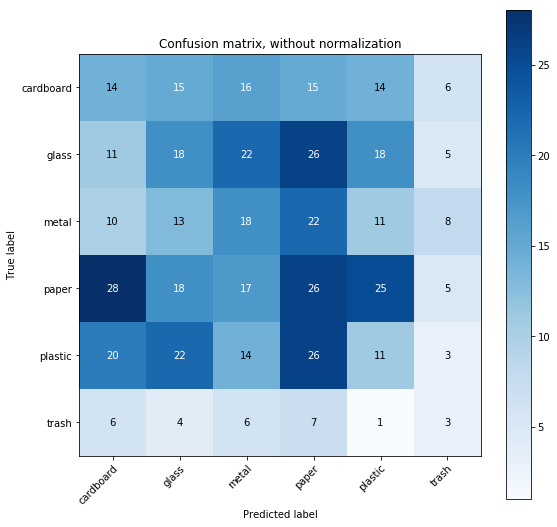

<Figure size 640x640 with 0 Axes>

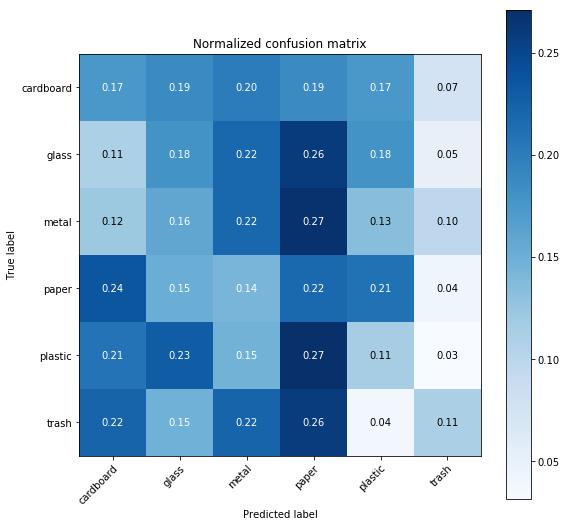

<Figure size 640x640 with 0 Axes>

In [54]:
from sklearn.utils.multiclass import unique_labels
plt.rcParams['figure.figsize'] = (9, 9)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
   # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig = plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
class_names = np.asarray(class_names)

# Plot non-normalized confusion matrix
plot_confusion_matrix(testGenerator.classes, y_pred, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(testGenerator.classes, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

#plt.show()